In [3]:
import random

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import rv_continuous

# Задача 4. Вариант 1.

Представьте, что вам нужно быстро создать некий программный продукт, в котором будут использоваться вероятностные модели. Возможно, вы будете использовать Python и модуль SciPy, в котором реализовано достаточно много математических алгоритмов и моделей, в том числе и вероятностно-статистических (подмодуль stats). Допустим, в вашей модели есть ”нестандартное” распределение (например, не реализованное в SciPy), для которого известна плотность, и вам нужно быстро реализовать распределение, то есть определить функцию распределения, квантили и прочие методы. Тогда идея унаследоваться от класса rv_continious кажется разумной: ведь достаточно переопределить метод, соответствующий плотности. Казалось бы отличная идея, плюс применили объектно-ориентированный подход. Но допустим, что вам понадобилось сгенерировать случайные числа (на самом деле псевдослучайные) из данного распределения, но вдруг что-то пойдёт не так, например, будет слишком долго работать... И вдруг нужно будет сообразить другие методы.

_Само задание:_

 * Для заданной плотности $p$ наследуйтесь от класса rv_continuous и сгенерируйте с помощью реализованного подкласса для вашего распределения n случайных чисел из данного распределения. Посмотрите, как будет работать алгоритм при росте $n$ (сразу большим $n$ не делайте). Убедитесь эмпирически, что распределение сгенерированных чисел согласуется с данным вероятностным законом.

 * Реализуйте генерацию для вашего распределения с помощью обратной к функции распределения (при написании функции для $F^{-1}$ вызов специальных функций, например, квантили стандартного нормального закона разрешается; не забыть аналитический вывод $F^{−1}$). Проведите тот же эксперимент.

 * Выберите еще один метод для генерации случайных чисел (можно, например, rejecting sampling, ratio of uniforms или другой метод). Опишите его математическое обоснование. Воспользуйтесь реализацией или сами реализуйте. Проведите тот же эксперимент.


$$
\boxed{
p(x) = 3x^2 e^{-x^3} \cdot 1(x \geq 0)
}
$$

# Подкласс rv_continuous

In [4]:
class MyRV_pdf(rv_continuous):
    """Класс для заданной плотности распределения."""

    def _pdf(self, x):
        """Плотность распределения."""
        if x < 0:
            return 0
        return 3 * x ** 2 * np.exp(-x ** 3)


class MyRV_cdf(rv_continuous):
    """Класс для заданной функции распределения."""

    def _cdf(self, x):
        """Функция распределения."""
        if x < 0:
            return 0
        return 1 - np.exp(-x ** 3)


class MyRV_ppf(rv_continuous):
    """Класс для заданной обратной функции распределения."""

    def _ppf(self, q):
        """Обратная функция распределения."""
        return (-np.log(1 - q)) ** (1 / 3)


class MyRV_reject(rv_continuous):
    """Класс для генерации методом rejection sampling."""

    def rvs(self, size):
        """Генерация случайных чисел методом rejection sampling."""
        samples = []
        c = 3.0
        while len(samples) < n:
            x = random.expovariate(1.0)
            u = random.uniform(0, c * np.exp(-x))
            f_x = 3 * x ** 2 * np.exp(-x ** 3)
            if u <= f_x:
                samples.append(x)
        return samples

In [5]:
def rvs_with_time(rv_continuous_function, n):
    """Генерация n случайных чисел с помощью функции rv_continuous_function и измерение времени."""
    import time
    start_time = time.time()
    samples = rv_continuous_function.rvs(size=n)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return samples, elapsed_time

In [11]:
def plot_results(samples, n, time, method_name):
    """Построение гистограммы и плотности распределения."""
    x = np.linspace(0, 3, 100)
    plt.hist(samples, bins=30, density=True, alpha=0.5, label=f'Samples: {n}, time: {time:.4f}s')
    plt.plot(x, 3 * x ** 2 * np.exp(-x ** 3), 'r-', lw=2, label='PDF')
    plt.title(f'Histogram and PDF using {method_name}')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

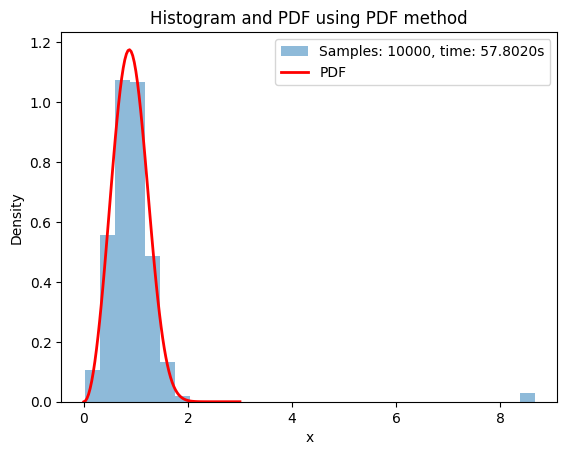

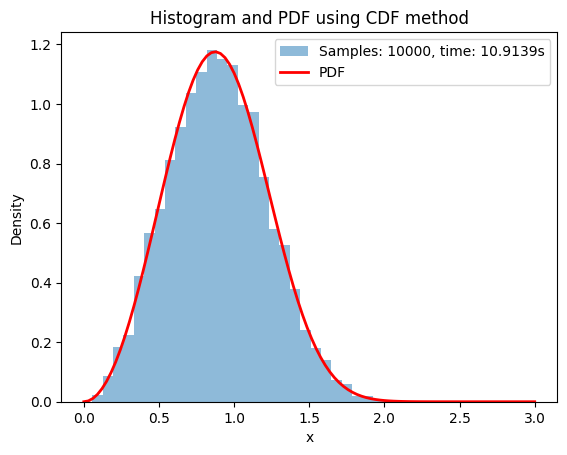

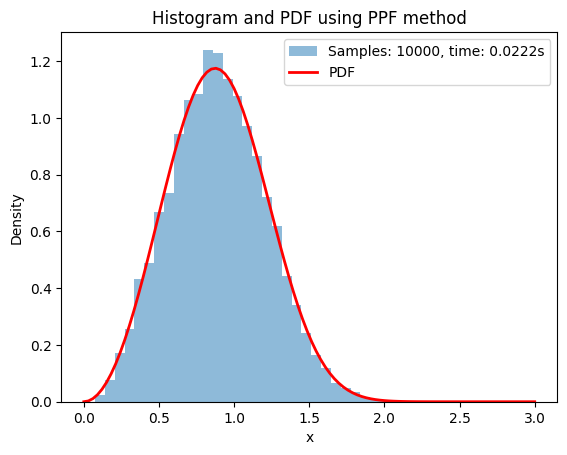

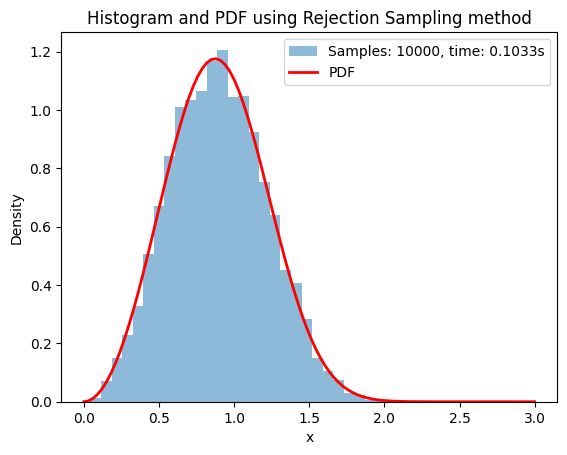

In [12]:
n = 10000
x = np.linspace(0, 3, 100)

my_rv_pdf = MyRV_pdf()
my_rv_cdf = MyRV_cdf()
my_rv_ppf = MyRV_ppf()
my_rv_reject = MyRV_reject()

samples_pdf, time_pdf = rvs_with_time(my_rv_pdf, n)
samples_cdf, time_cdf = rvs_with_time(my_rv_cdf, n)
samples_ppf, time_ppf = rvs_with_time(my_rv_ppf, n)
samples_reject, time_reject = rvs_with_time(my_rv_reject, n)

plot_results(samples_pdf, n, time_pdf, 'PDF method')
plot_results(samples_cdf, n, time_cdf, 'CDF method')
plot_results(samples_ppf, n, time_ppf, 'PPF method')
plot_results(samples_reject, n, time_reject, 'Rejection Sampling method')

# Выводы

Изначально можно было предсказать, что метод обратной функции распределения будет самым быстрым, так как именно через неё и реализована генерация ПСЧ. Таким образом:

1. Метод через плотность оказался самым медленным, так как для генерации приходилось приводить плотность к функции распределения, а потом получать обратную функцию распределения. Это также и привело к выбросу у цифры 8, что может быть связано с погрешностью вычислений.
2. Метод через функцию распределения оказался быстрее, так как её нужно было только привести к обратной функции распределения.
3. Метод обратной функции распределения оказался самым быстрым, что и было ожидаемо.
4. Метод rejection sampling оказался чуть медленнее, чем метод обратной функции распределения.

Таким образом, можно сделать вывод, что для генерации ПСЧ из заданного распределения лучше всего использовать метод обратной функции распределения. Либо же рализовывать свой метод rvs, как в случае с rejection sampling. Выходит, что приведение к PPF - требует много времени, а также может приводить к погрешностям.